In [1]:
import numpy as np
from numpy import random

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import math

In [5]:
from scipy.stats import bernoulli

# Functions

In [6]:
def sample_service_times(num_jobs, parameter):
    a = parameter
    return np.array([math.floor(t)+100 for t in random.pareto(a, num_jobs)])

In [7]:
def remaining_jobs(remaining_service_times):
    return np.array([i for i in range(N) if remaining_service_times[i] >= 1])

def holding_cost(mean_values, jobs):
    return np.sum([mean_values[i] for i in jobs])

In [8]:
def select_job(t, samples, service_times, jobs):
    c_mu = np.array([(np.mean(samples[i][0:t+1]) / service_times[i]) for i in jobs])
    return jobs[np.argmax(c_mu)]

def serve(i, remaining_service_times):
    remaining_service_times[i] -= 1
    
def complete(i, remaining_service_times):
    remaining_service_times[i] = 0

In [9]:
def optimal(mean_values, service_times):
    sorted_jobs = np.argsort(- mean_values / service_times)
    total_cost = 0
    for i in range(N):
        for j in range(N):
            if j>= i:
                total_cost += mean_values[sorted_jobs[j]] * service_times[sorted_jobs[i]]
    return total_cost

In [10]:
def preemptive(mean_values, service_times, samples):
    remaining_service_times = service_times
    initial_times = np.array([service_times[i] for i in range(N)])
    total_holding_cost = 0
    active_jobs = np.array(range(N))
    t = 0
    while active_jobs.size > 1:
        total_holding_cost += holding_cost(mean_values, active_jobs)
        #serve(select_job(t, samples, service_times, active_jobs), remaining_service_times)
        serve(select_job(t, samples, initial_times, active_jobs), remaining_service_times)
        active_jobs = remaining_jobs(remaining_service_times)
        t += 1
    total_holding_cost += remaining_service_times[active_jobs[0]] * mean_values[active_jobs[0]]
    return total_holding_cost

In [11]:
def nonpreemptive(mean_values, service_times, samples):
    remaining_service_times = service_times
    total_holding_cost = 0
    t = 0
    for i in range(N):
        active_jobs = remaining_jobs(remaining_service_times)
        selected = select_job(t, samples, service_times, active_jobs)
        total_holding_cost += remaining_service_times[selected]*holding_cost(mean_values, active_jobs)
        t +=  remaining_service_times[selected]
        complete(selected, remaining_service_times)
    return total_holding_cost

In [12]:
def preemptive_then_nonpreemptive(mean_values, service_times, samples):
    max_service_time = np.max(service_times)
    S = math.floor( (max_service_time**(2/3)) * (np.log(N*max_service_time)) / C)
    S = np.min([np.min(service_times), S])
    remaining_service_times = service_times
    total_holding_cost = 0

    active_jobs = np.array(range(N))
    for t in range(S):
        total_holding_cost += holding_cost(mean_values, active_jobs)
        serve(select_job(t, samples, service_times, active_jobs), remaining_service_times)
        active_jobs = remaining_jobs(remaining_service_times)
    
    time_steps_past = S
    while active_jobs.size > 0:
        job_chosen = select_job(time_steps_past, samples, service_times, active_jobs)
        remaining_service_time = remaining_service_times[job_chosen]
        total_holding_cost += remaining_service_time*holding_cost(mean_values, active_jobs)
        time_steps_past += remaining_service_time
        complete(job_chosen, remaining_service_times)
        active_jobs = remaining_jobs(remaining_service_times)
    return total_holding_cost

## Sampling mean holding costs

In [13]:
eps_list = np.array([0.01*i for i in range(51)])
eps_list[0] = 0.001

## Testing different values of $\epsilon$

In [16]:
it_num = 500

N = 20
C = 100

for eps in eps_list:
    for i in range(it_num):
        mean_values = np.random.uniform(0.5-eps, 0.5+eps, N)
        service_times = sample_service_times(N, 0.7)
        service_times1 = np.array([service_times[i] for i in range(N)])
        service_times2 = np.array([service_times[i] for i in range(N)])
        service_times3 = np.array([service_times[i] for i in range(N)])
        samples = np.array([bernoulli.rvs(mean_values[i], size=np.sum(service_times)) for i in range(N)])
        
        OPT = optimal(mean_values, service_times)
        pre = preemptive(mean_values, service_times1, samples) - OPT
        non = nonpreemptive(mean_values, service_times2, samples) - OPT
        pre_non_pre = preemptive_then_nonpreemptive(mean_values, service_times3, samples) - OPT

        df = pd.read_csv('results_raw_data.csv')
        df = df.append({'num_jobs': N, 'service_time': 10000, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                        'preemptive': pre, 'non-preemptive': non, 'pre-non-pre': pre_non_pre}, ignore_index = True)
        df.to_csv('results_raw_data.csv', index=False)

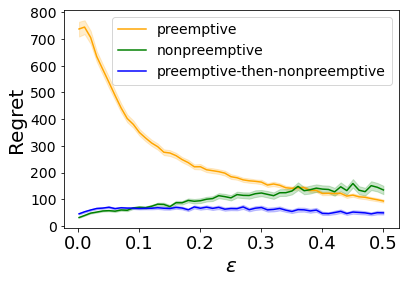

In [6]:
df = pd.read_csv('results/different/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 10000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive'], label='preemptive', color = 'orange')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive'], label='nonpreemptive', color = 'green')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre'], label='preemptive-then-nonpreemptive', color = 'blue')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)
plt.savefig('hetero-regret.pdf', bbox_inches = 'tight')

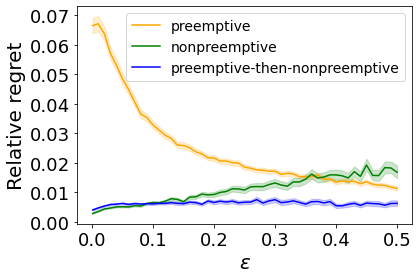

In [9]:
df = pd.read_csv('results/different/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 10000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive']/filtered['OPT'], label='preemptive', color = 'orange')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive']/filtered['OPT'], label='nonpreemptive', color = 'green')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre']/filtered['OPT'], label='preemptive-then-nonpreemptive', color = 'blue')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Relative regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('hetero-relative.pdf', bbox_inches = 'tight')

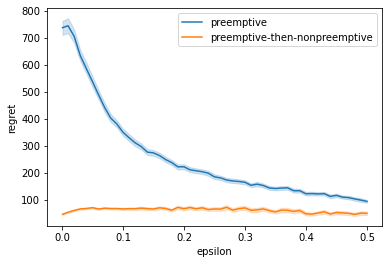

In [24]:
df = pd.read_csv('results/different/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 10000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive'], label='preemptive')
#sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive'], label='nonpreemptive')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre'], label='preemptive-then-nonpreemptive')
plt.xlabel("epsilon")
plt.ylabel("regret")
plt.legend()

In [246]:
(sample_service_times(20, 0.7)*10)

array([ 1000,  1000,  1000,  1230,  1000,  1090,  1000,  1000,  1000,
        2290,  1060,  1000,  1150,  4310,  7320,  1000,  1000,  1000,
       54240,  1000])

In [316]:
mean_values = np.random.uniform(0.5-eps, 0.5+eps, N)
service_times = sample_service_times(20, 0.7)*10
service_times1 = np.array([service_times[i] for i in range(N)])
service_times2 = np.array([service_times[i] for i in range(N)])
service_times3 = np.array([service_times[i] for i in range(N)])
samples = np.array([bernoulli.rvs(mean_values[i], size=np.sum(service_times)) for i in range(N)])

In [317]:
OPT = optimal(mean_values, service_times)
OPT

106956.75865752654

In [318]:
preemptive(mean_values, service_times1, samples)

107436.65590690228

In [319]:
nonpreemptive(mean_values, service_times2, samples)

110419.3210874263

In [320]:
preemptive_then_nonpreemptive(mean_values, service_times3, samples)

107214.10514158772

In [273]:
b = a


In [274]:
b

array([1, 2, 3])

In [275]:
b[0] += 5

In [276]:
a

array([6, 2, 3])

In [297]:
sorted_jobs = np.argsort(- mean_values / service_times)

In [300]:
mean_values / service_times

array([0.00049926, 0.00050064, 0.00050073, 0.00048979, 0.00048504,
       0.0004803 , 0.00050014, 0.00032683, 0.00049961, 0.00049065,
       0.00048588, 0.00047678, 0.0004893 , 0.00048103, 0.00049962,
       0.00037103, 0.00050039, 0.00049043, 0.00031898, 0.00038438])

In [302]:
np.sort(-mean_values / service_times)

array([-0.00050073, -0.00050064, -0.00050039, -0.00050014, -0.00049962,
       -0.00049961, -0.00049926, -0.00049065, -0.00049043, -0.00048979,
       -0.0004893 , -0.00048588, -0.00048504, -0.00048103, -0.0004803 ,
       -0.00047678, -0.00038438, -0.00037103, -0.00032683, -0.00031898])

In [303]:
np.argsort(-mean_values / service_times)

array([ 2,  1, 16,  6, 14,  8,  0,  9, 17,  3, 12, 10,  4, 13,  5, 11, 19,
       15,  7, 18])

In [16]:
np.random.pareto(0.7, 20)

array([5.74509093e-01, 1.43041053e+00, 2.90248839e+00, 1.52375277e-02,
       1.40464313e+00, 1.73233920e+01, 9.38076711e-03, 1.58469849e+02,
       1.92837092e+01, 1.20369003e-01, 1.45591237e+00, 1.77408766e+01,
       3.70782934e+02, 4.01078778e+01, 2.59561982e+00, 4.51197878e+00,
       3.22400968e+00, 3.03853680e+00, 1.90603490e+00, 1.42124593e-02])

In [72]:
np.array(random.pareto(2, 20))*10

array([4.51461400e+00, 1.17831122e+00, 3.09719257e+00, 4.53244207e+01,
       9.40295173e-01, 6.35535242e-01, 9.45401689e-01, 9.59221260e+00,
       3.11054638e+02, 3.83612025e+00, 2.44251792e-01, 1.80782737e+00,
       1.26596727e+00, 3.45164165e+00, 2.59205360e+01, 9.66192269e+00,
       4.07661506e+00, 8.25894511e+00, 2.03290901e+00, 3.33874276e+01])

In [52]:
sample_service_times(20, 2)*10

array([1010, 1000, 1000, 1000, 1000, 1000, 1010, 1000, 1000, 1000, 1000,
       1020, 1000, 1000, 1020, 1000, 1020, 1000, 1000, 1030])